In [1]:
import sys
sys.path.append("/home/sergio/TinyYOLOv3-Pedestrian-Detection")

from YOLOblocks import TinyYOLOv3,BasicBlock,PredictionLayer#,YOLOLossBasicBlock
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
#from tensorflow.python.tools import freeze_graph
from skimage.io import imread,imshow
#from skimage.transform import resize 
import time
#from tensorflow.compat.v1.image import decode_image
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import os
import pandas as pd

## Dataset preparation

In [2]:
os.chdir("/home/sergio/Documents/COCODataset")
annotations_val_set = pd.read_csv("COCO_annotations_val.csv")
annotations_val_set.drop("Unnamed: 0",axis=1)

,file_name,xmin,ymin,xmax,ymax
0,000000532481.jpg,0.391906,0.394977,0.501453,0.547277
1,000000532481.jpg,0.446172,0.869859,0.465031,0.914953
2,000000458755.jpg,0.107859,0.078646,0.901687,0.986521
3,000000458755.jpg,0.885938,0.002646,1.000000,0.183604
4,000000458755.jpg,0.921906,0.191021,0.999437,0.393250
...,...,...,...,...,...
10999,000000098287.jpg,0.870193,0.408687,0.882000,0.440844
11000,000000098287.jpg,0.419277,0.389062,0.455422,0.418750
11001,000000417779.jpg,0.736297,0.178083,0.765656,0.267104
11002,000000024567.jpg,0.000000,0.000000,0.876958,0.745188


In [3]:
os.chdir("/home/sergio/Documents/COCODataset/pedestrian_dataset_val")
validation_images_names = os.listdir()
print(len(validation_images_names))

2693


In [4]:
anchors =[[0.026,0.062],[0.067,0.183],[0.128,0.323],[0.343,0.650]]
#anchors =tf.constant(np.array([[0,0,0.026,0.062],[0,0,0.067,0.183],[0,0,0.128,0.323],[0,0,0.343,0.650]]),dtype=tf.float32)
model = TinyYOLOv3(1,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.5)
model.build(batch_input_shape=(None,416,416,3))
print(model.load_weights_darknet("/home/sergio/TinyYOLOv3-Pedestrian-Detection/yolov3-tiny.weights"))
model.load_weights('/home/sergio/Documents/weights_saved/pesos_160_to_180_epochs_nadam_2_1_4_1_0dot0001_el_bueno')

Solo es una clase
(None, 1690, 1, 4)
Pesos de la convolucion (432,)
CONV SHAPE (16, 3, 3, 3)
Pesos de la convolucion (4608,)
CONV SHAPE (32, 16, 3, 3)
Pesos de la convolucion (18432,)
CONV SHAPE (64, 32, 3, 3)
Pesos de la convolucion (73728,)
CONV SHAPE (128, 64, 3, 3)
Pesos de la convolucion (294912,)
CONV SHAPE (256, 128, 3, 3)
Pesos de la convolucion (1179648,)
CONV SHAPE (512, 256, 3, 3)
Pesos de la convolucion (4718592,)
CONV SHAPE (1024, 512, 3, 3)
Pesos de la convolucion (262144,)
CONV SHAPE (256, 1024, 1, 1)
Pesos de la convolucion (1179648,)
CONV SHAPE (512, 256, 3, 3)
Pesos de la convolucion (130560,)
CONV SHAPE (255, 512, 1, 1)
Pesos de la convolucion (32768,)
CONV SHAPE (128, 256, 1, 1)
Pesos de la convolucion (884736,)
CONV SHAPE (256, 384, 3, 3)
Pesos de la convolucion (65280,)
CONV SHAPE (255, 256, 1, 1)
8858734


In [5]:
def get_iou_matrix_tf(box_arr1, box_arr2):
    #print(box_arr1)
    #print(box_arr2)
    x11, y11, x12, y12 = tf.split(box_arr1, 4, axis=1)
    x21, y21, x22, y22 = tf.split(box_arr2, 4, axis=1)
    xA = tf.maximum(x11, tf.transpose(x21))
    #print(xA)
    yA = tf.maximum(y11, tf.transpose(y21))
    #print(yA)
    xB = tf.minimum(x12, tf.transpose(x22))
    #print(xB)
    yB = tf.minimum(y12, tf.transpose(y22))
    #print(yB)
    interArea = tf.maximum((xB - xA + 1e-9), 0) * tf.maximum((yB - yA + 1e-9), 0)
    #print("interseccion",interArea)
    boxAArea = (x12 - x11 + 1e-9) * (y12 - y11 + 1e-9)
    #print("area gt",boxAArea)
    boxBArea = (x22 - x21 + 1e-9) * (y22 - y21 + 1e-9)
    #print("area pre",boxBArea)
    iou = interArea / (boxAArea + tf.transpose(boxBArea) - interArea)
    #print(iou)
    return tf.cast(iou>=0.5,dtype=tf.int32) #iou


In [6]:
np.arange(0,1.1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [7]:
len(annotations_val_set)

11004

In [18]:
import time

inicio = time.time()

precision=[]
recall = []
tp_total = []
fp_total = []
total_predicted_boxes=[]
thresholds = [0.0001,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.999]

for thresh in thresholds:
    tp = 0
    fp = 0
    fn = 0
    total_pred_boxes = 0
    print(thresh)
    anchors =[[0.026,0.062],[0.067,0.183],[0.128,0.323],[0.343,0.650]]
    #anchors =tf.constant(np.array([[0,0,0.026,0.062],[0,0,0.067,0.183],[0,0,0.128,0.323],[0,0,0.343,0.650]]),dtype=tf.float32)
    model = TinyYOLOv3(1,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=thresh)
    model.build(batch_input_shape=(None,416,416,3))
    #print(model.load_weights_darknet("/home/sergio/TinyYOLOv3-Pedestrian-Detection/yolov3-tiny.weights"))
    model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_to_70_epoch_nadam_0dot0001_msle_exp_mse').expect_partial()    
    
    
    
    for image in validation_images_names:
        #print(annotations_val_set[annotations_val_set.file_name==image])
        groud_truth_bboxes = annotations_val_set[annotations_val_set.file_name==image].values[:,2:].astype(np.float32)
        #print(groud_truth_bboxes)
        img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
        img = tf.expand_dims(img_raw, 0)
        img = tf.image.resize(img, (416, 416))/255

        outputs = model(img);
        #print(outputs[0].numpy())
        predicted_bboxes = outputs[0].numpy()[0,0:outputs[3][0].numpy(),:]
        total_pred_boxes +=predicted_bboxes.shape[0]
        #print(predicted_bboxes)
        #print("")
        iou_matrix = get_iou_matrix_tf(groud_truth_bboxes,predicted_bboxes).numpy()
        #print(iou_matrix)
        suma_iou = iou_matrix.sum(axis=1)
        #print(suma_iou)
        #print(suma_iou)
        tp_image = np.where(suma_iou>=1)[0].shape[0]
        #print(tp_image)
        #fn_image = fp_image =np.where(suma_iou==0)[0].shape[0]
        fp_image=predicted_bboxes.shape[0] - tp_image

        tp += tp_image
        fp += fp_image
        #fn += fn_image

        tp_image=0
        fn_image = 0
        #fp_image=0
        
    precision_one = tp/(tp+fp)
    recall_one = tp/11004
    
    precision.append(precision_one)
    recall.append(recall_one)
    tp_total.append(tp)
    fp_total.append(fp)
    total_predicted_boxes.append(total_pred_boxes)
    
    precision_one = 0
    recall_one = 0
        #break
    
fin = time.time()

#print(fin-inicio)
#print(2693/(fin-inicio))

0.0001
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.1
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.2
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.3
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.4
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.5
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.6
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.7
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.8
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.9
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.999
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)


In [19]:
tp_total

[3382, 2373, 2083, 1853, 1655, 1483, 1316, 1130, 952, 703, 75]

In [20]:
fp_total

[7928, 3357, 2836, 2429, 2135, 1840, 1588, 1349, 1072, 727, 75]

In [21]:
precision

[0.299027409372237,
 0.41413612565445024,
 0.4234600528562716,
 0.43274170948155066,
 0.4366754617414248,
 0.44628347878423114,
 0.453168044077135,
 0.45582896329164985,
 0.47035573122529645,
 0.4916083916083916,
 0.5]

In [22]:
np.mean(precision)

0.43848048800842165

In [17]:
tp_total

[3610, 2426, 2132, 1906, 1715, 1559, 1380, 1174, 976, 744, 87]

In [18]:
fp_total

[8979, 3632, 2996, 2595, 2280, 2026, 1760, 1472, 1212, 879, 110]

In [19]:
precision

[0.2867582810390023,
 0.4004621987454606,
 0.4157566302652106,
 0.42346145301044213,
 0.4292866082603254,
 0.43486750348675035,
 0.4394904458598726,
 0.4436885865457294,
 0.4460694698354662,
 0.4584103512014787,
 0.4416243654822335]

In [20]:
np.mean(precision)

0.4199887176119974

In [9]:
tp_total

[3699, 2563, 2187, 1907, 1692, 1483, 1277, 1072, 884, 614, 55]

In [10]:
fp_total

[10669, 3972, 3231, 2722, 2324, 1991, 1665, 1361, 1039, 672, 36]

In [11]:
precision

[0.2574471046770601,
 0.39219586840091814,
 0.40365448504983387,
 0.41196802765176066,
 0.4213147410358566,
 0.4268854346574554,
 0.4340584636301835,
 0.44060830250719274,
 0.4596983879355174,
 0.4774494556765163,
 0.6043956043956044]

In [12]:
np.mean(precision)

0.42997053414708175

In [9]:
tp_total

[3308, 2173, 1950, 1753, 1595, 1440, 1278, 1107, 935, 693, 90]

In [10]:
fp_total

[12850, 3412, 2936, 2605, 2332, 2070, 1828, 1589, 1327, 969, 146]

In [11]:
precision

[0.20472830795890581,
 0.3890778871978514,
 0.39909946786737616,
 0.40224873795318955,
 0.4061624649859944,
 0.41025641025641024,
 0.41146168705730846,
 0.41060830860534125,
 0.41335101679929265,
 0.41696750902527074,
 0.3813559322033898]

In [12]:
np.mean(precision)

0.38593797544639374

In [9]:
tp_total

[3308, 2755, 2464, 2209, 2029, 1856, 1658, 1457, 1211, 918, 123]

In [10]:
fp_total

[12850, 4799, 4039, 3487, 3096, 2764, 2443, 2092, 1755, 1289, 188]

In [11]:
precision

[0.20472830795890581,
 0.36470743976701087,
 0.3789020452099031,
 0.38781601123595505,
 0.39590243902439026,
 0.4017316017316017,
 0.40429163618629604,
 0.410538179768949,
 0.40829399865138233,
 0.41594925237879476,
 0.3954983922829582]

In [12]:
np.mean(precision)

0.37894175492692245

In [ ]:
[3519, 2884, 2559, 2309, 2061, 1855, 1634, 1427, 1176, 864, 120]
[18025, 5944, 4702, 4006, 3453, 2983, 2589, 2181, 1747, 1252, 162]

In [9]:
tp_total

[3616, 2930, 2608, 2323, 2104, 1908, 1691, 1477, 1226, 921, 123]

In [10]:
fp_total

[17928, 5596, 4622, 3910, 3410, 2985, 2601, 2184, 1815, 1306, 188]

In [11]:
precision

[0.16784255477163015,
 0.3436547032606146,
 0.3607192254495159,
 0.3726937269372694,
 0.3815741748277113,
 0.38994481912936846,
 0.3939888164026095,
 0.40344168260038243,
 0.40315685629727066,
 0.4135608441850022,
 0.3954983922829582]

In [12]:
np.mean(precision)

0.36600689055857566

In [ ]:
[3519, 2884, 2559, 2309, 2061, 1855, 1634, 1427, 1176, 864, 120]
[18025, 5944, 4702, 4006, 3453, 2983, 2589, 2181, 1747, 1252, 162]

In [9]:
tp_total

[3858, 3053, 2697, 2384, 2142, 1931, 1702, 1485, 1230, 924, 123]

In [10]:
fp_total

[23072, 6172, 4993, 4152, 3565, 3083, 2659, 2220, 1830, 1308, 188]

In [12]:
precision

[0.14326030449313035,
 0.33094850948509485,
 0.3507152145643693,
 0.36474908200734396,
 0.37532854389346415,
 0.3851216593538093,
 0.3902774592983261,
 0.4008097165991903,
 0.4019607843137255,
 0.41397849462365593,
 0.3954983922829582]

In [14]:
np.mean(precision)

0.3593316509922789

In [20]:
fp_total

[28155, 6838, 5364, 4373, 3699, 3154, 2700, 2242, 1837, 1309, 188]

In [21]:
precision

[0.12875974749350166,
 0.31722416375436846,
 0.34054585689697564,
 0.3575730865285735,
 0.37016856802315684,
 0.3827788649706458,
 0.38803263825929285,
 0.3989276139410188,
 0.40123859191655803,
 0.41379310344827586,
 0.3954983922829582]

In [22]:
np.mean(precision)

0.35404914795593867

In [23]:
recall

[0.3781352235550709,
 0.2887131952017448,
 0.2517266448564158,
 0.2211922937113777,
 0.19756452199200292,
 0.1777535441657579,
 0.15557978916757542,
 0.13522355507088332,
 0.1118684114867321,
 0.08396946564885496,
 0.011177753544165758]

In [24]:
np.mean(recall)

0.1829913089455074

In [20]:
import time

inicio = time.time()

precision=[]
recall = []
tp_total = []
fp_total = []

thresholds = [0.0001,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.999]

for thresh in thresholds:
    tp = 0
    fp = 0
    fn = 0
    print(thresh)
    anchors =[[0.026,0.062],[0.067,0.183],[0.128,0.323],[0.343,0.650]]
    #anchors =tf.constant(np.array([[0,0,0.026,0.062],[0,0,0.067,0.183],[0,0,0.128,0.323],[0,0,0.343,0.650]]),dtype=tf.float32)
    model = TinyYOLOv3(1,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=thresh)
    model.build(batch_input_shape=(None,416,416,3))
    #print(model.load_weights_darknet("/home/sergio/TinyYOLOv3-Pedestrian-Detection/yolov3-tiny.weights"))
    model.load_weights('/home/sergio/Documents/weights_saved/pesos_160_to_180_epochs_nadam_2_1_4_1_0dot0001_el_bueno').expect_partial()    
    
    
    
    for image in validation_images_names:
        #print(annotations_val_set[annotations_val_set.file_name==image])
        groud_truth_bboxes = annotations_val_set[annotations_val_set.file_name==image].values[:,2:].astype(np.float32)
        #print(groud_truth_bboxes)
        img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)
        img = tf.expand_dims(img_raw, 0)
        img = tf.image.resize(img, (416, 416))/255

        outputs = model(img);
        #print(outputs[0].numpy())
        predicted_bboxes = outputs[0].numpy()[0,0:outputs[3][0].numpy(),:]
        #print(predicted_bboxes)
        #print("")
        iou_matrix = get_iou_matrix_tf(groud_truth_bboxes,predicted_bboxes).numpy()
        #print(iou_matrix)
        suma_iou = iou_matrix.sum(axis=1)
        #print(suma_iou)
        #print(suma_iou)
        tp_image = np.where(suma_iou>=1)[0].shape[0]
        #print(tp_image)
        #fn_image = fp_image =np.where(suma_iou==0)[0].shape[0]
        fp_image=predicted_bboxes.shape[0] - tp_image

        tp += tp_image
        fp += fp_image
        #fn += fn_image

        tp_image=0
        fn_image = 0
        #fp_image=0
        
    precision_one = tp/(tp+fp)
    recall_one = tp/11004
    
    precision.append(precision_one)
    recall.append(recall_one)
    tp_total.append(tp)
    fp_total.append(fp)
    
    precision_one = 0
    recall_one = 0
        #break
    
fin = time.time()

#print(fin-inicio)
#print(2693/(fin-inicio))

0.0001
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.1
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.2
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.3
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.4
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.5
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.6
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.7
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.8
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.9
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)
0.999
Solo es una clase
(None, 1690, 1, 4)
Solo es una clase
(1, 1690, 1, 4)


In [21]:
tp_total

[3100, 2172, 1895, 1701, 1533, 1389, 1244, 1067, 885, 670, 89]

In [22]:
fp_total

[8116, 3532, 2974, 2606, 2306, 2057, 1800, 1523, 1249, 936, 118]

In [23]:
precision

[0.27639087018544933,
 0.3807854137447405,
 0.3891969603614705,
 0.3949384722544695,
 0.3993227402969523,
 0.4030760301799187,
 0.40867279894875164,
 0.41196911196911196,
 0.4147141518275539,
 0.41718555417185554,
 0.42995169082125606]

In [24]:
np.mean(precision)

0.39329125406922993

In [14]:
tp_total

[3217, 2172, 1895, 1701, 1533, 1389, 1244, 1067, 885, 670, 89]

In [15]:
fp_total

[12941, 3532, 2974, 2606, 2306, 2057, 1800, 1523, 1249, 936, 118]

In [16]:
precision

[0.19909642282460702,
 0.3807854137447405,
 0.3891969603614705,
 0.3949384722544695,
 0.3993227402969523,
 0.4030760301799187,
 0.40867279894875164,
 0.41196911196911196,
 0.4147141518275539,
 0.41718555417185554,
 0.42995169082125606]

0.3862644861273352

In [14]:
tp_total

[3217, 2709, 2427, 2206, 1985, 1797, 1596, 1403, 1167, 862, 120]

In [15]:
fp_total

[12941, 5114, 4158, 3608, 3164, 2770, 2434, 2080, 1694, 1231, 162]

In [16]:
precision

[0.19909642282460702,
 0.3462865908219353,
 0.36856492027334853,
 0.37942896456828346,
 0.38551174985434067,
 0.39347492883731117,
 0.39602977667493794,
 0.40281366637955784,
 0.40789933589653965,
 0.4118490205446727,
 0.425531914893617]

In [17]:
np.mean(precision)

0.37422611741537737

In [14]:
tp_total

[3519, 2884, 2559, 2309, 2061, 1855, 1634, 1427, 1176, 864, 120]

In [15]:
fp_total

[18025, 5944, 4702, 4006, 3453, 2983, 2589, 2181, 1747, 1252, 162]

In [16]:
precision

[0.1633401411065726,
 0.3266878115088355,
 0.35243079465638344,
 0.36563737133808394,
 0.3737758433079434,
 0.38342290202563045,
 0.3869287236561686,
 0.395509977827051,
 0.4023263770099213,
 0.40831758034026466,
 0.425531914893617]

In [17]:
np.mean(precision)

0.36217358524277016

In [18]:
recall

[0.3197928026172301,
 0.26208651399491095,
 0.23255179934569248,
 0.20983278807706288,
 0.18729552889858234,
 0.16857506361323155,
 0.148491457651763,
 0.1296801163213377,
 0.10687022900763359,
 0.07851690294438386,
 0.010905125408942203]

In [19]:
np.mean(recall)

0.16859984798916094

In [20]:
recall

[0.477735368956743,
 0.37795347146492186,
 0.33142493638676845,
 0.29498364231188656,
 0.25926935659760086,
 0.23109778262450018,
 0.2050163576881134,
 0.17802617230098147,
 0.14694656488549618,
 0.10814249363867684]

In [21]:
print(tp)
print(fp)
print(fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print(precision)
print(recall)

1190
931
0
0.5610561056105611
1.0


In [9]:
iou_matrix

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)

In [10]:
fake_suma_iou = np.array([0,1,1,0,2,3,1])
#fake_suma_iou = np.array([0,1,2])

In [11]:
tp_image = np.where(fake_suma_iou>=1)[0].shape[0]
fn_image = fp_image =np.where(fake_suma_iou==0)[0].shape[0]
fp_image=fp_image + np.sum(fake_suma_iou[np.where(fake_suma_iou>1)[0]]-1)

In [12]:
print(tp_image)
print(fn_image)
print(fp_image)

5
2
5


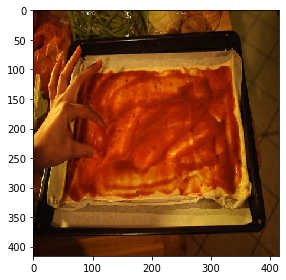

In [13]:
imshow(img.numpy()[0,:,:,:])

In [14]:
ground_truth = annotations_val_set[annotations_val_set.file_name==image].values[:,2:].astype(np.float32)

In [15]:
ground_truth*416

array([[  0.      ,  60.901993, 124.54649 , 271.71582 ]], dtype=float32)

In [16]:
predicted =outputs[0].numpy()[0,0:outputs[3][0].numpy(),:]

In [17]:
predicted

array([[5.07258773e-01, 2.49375120e-01, 5.74728370e-01, 6.77042127e-01],
       [5.49546957e-01, 3.12932193e-01, 6.04627132e-01, 6.11308932e-01],
       [4.03661907e-01, 2.24301398e-01, 5.29107690e-01, 5.51649034e-01],
       [0.00000000e+00, 2.52826273e-01, 3.62316728e-01, 8.25129211e-01],
       [5.23441195e-01, 3.15338492e-01, 5.54700494e-01, 3.77405882e-01],
       [1.62017794e-04, 6.97114289e-01, 1.63021468e-04, 9.19377625e-01],
       [4.71134275e-01, 3.19938660e-01, 5.31406999e-01, 6.04038417e-01],
       [1.76049798e-04, 7.46622443e-01, 1.77213165e-04, 9.46964741e-01],
       [3.48556578e-01, 1.94655418e-01, 7.31553733e-01, 7.31992602e-01],
       [1.11369889e-04, 6.94792807e-01, 1.12353264e-04, 8.44857037e-01],
       [5.19336879e-01, 2.62916863e-01, 5.59574187e-01, 3.53607774e-01],
       [1.18329874e-04, 2.16454819e-01, 1.18788841e-04, 4.76958394e-01],
       [1.17841242e-04, 2.49680132e-01, 1.18288495e-04, 5.20503640e-01],
       [0.00000000e+00, 7.15749204e-01, 1.66194364e

In [18]:
get_iou_matrix_tf(ground_truth, predicted)

<tf.Tensor: shape=(1, 20), dtype=int32, numpy=
array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>

In [10]:
tf.random.set_seed(0)

from tensorflow.keras.metrics import TrueNegatives,TruePositives,FalseNegatives,FalsePositives,Precision,Recall

opt = tf.keras.optimizers.Nadam(learning_rate=0.001)

losses = {"output_1": loss_xy,
          "output_2": loss_wh,
          "output_3":loss_objectness,
          "output_4":loss_no_objectness
          
}

metrics = {"output_3":[Precision(),Recall(),TrueNegatives(),TruePositives(),FalseNegatives(),FalsePositives()]}
model.compile(optimizer=opt, loss=losses,metrics=metrics,loss_weights=[2,1,4,1])
os.chdir("/home/sergio/Documents/pedestrian_dataset_train_tfr")

In [9]:
history = model.fit(train_dataset, epochs=10,validation_data=val_dataset)

Se redimensiona la salida de la CNN a: (None, 338, 5)
Se redimensiona la salida de la CNN a: (None, 1352, 5)
Epoch 1/10
Se redimensiona la salida de la CNN a: (None, 338, 5)
Se redimensiona la salida de la CNN a: (None, 1352, 5)
Se redimensiona la salida de la CNN a: (None, 338, 5)
Se redimensiona la salida de la CNN a: (None, 1352, 5)
   9213/Unknown - 655s 71ms/step - loss: 43.9426 - output_1_loss: 6.2576 - output_2_loss: 2.4306 - output_3_loss: 0.2216 - output_4_loss: 28.1102 - output_3_precision: 0.3717 - output_3_recall: 0.0751 - output_3_true_negatives: 123948400.0000 - output_3_true_positives: 40042.0000 - output_3_false_negatives: 493492.0000 - output_3_false_positives: 67688.0000Se redimensiona la salida de la CNN a: (None, 338, 5)
Se redimensiona la salida de la CNN a: (None, 1352, 5)
9213/9213 [==============================] - 664s 72ms/step - loss: 43.9426 - output_1_loss: 6.2576 - output_2_loss: 2.4306 - output_3_loss: 0.2216 - output_4_loss: 28.1102 - output_3_precision:

# DESDE AQUI

In [1]:
import sys
sys.path.append("/home/sergio/TinyYOLOv3-Pedestrian-Detection")

from YOLOblocks import TinyYOLOv3,BasicBlock,PredictionLayer#,YOLOLossBasicBlock
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
#from tensorflow.python.tools import freeze_graph
from skimage.io import imread,imshow
#from skimage.transform import resize 
import time
#from tensorflow.compat.v1.image import decode_image
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import os
import pandas as pd

In [2]:
anchors =[[0.026,0.062],[0.067,0.183],[0.128,0.323],[0.343,0.650]]
#anchors =tf.constant(np.array([[0,0,0.026,0.062],[0,0,0.067,0.183],[0,0,0.128,0.323],[0,0,0.343,0.650]]),dtype=tf.float32)
model = TinyYOLOv3(1,anchor_boxes=anchors,train=False,mode = "finetuning",obj_threshold=0.0001)
model.build(batch_input_shape=(None,416,416,3))
print(model.load_weights_darknet("/home/sergio/TinyYOLOv3-Pedestrian-Detection/yolov3-tiny.weights"))
model.load_weights('/home/sergio/Documents/weights_saved/pesos_1241_50_to_70_epoch_nadam_0dot0001_msle_exp_mse')

Solo es una clase
(None, 1690, 1, 4)
Pesos de la convolucion (432,)
CONV SHAPE (16, 3, 3, 3)
Pesos de la convolucion (4608,)
CONV SHAPE (32, 16, 3, 3)
Pesos de la convolucion (18432,)
CONV SHAPE (64, 32, 3, 3)
Pesos de la convolucion (73728,)
CONV SHAPE (128, 64, 3, 3)
Pesos de la convolucion (294912,)
CONV SHAPE (256, 128, 3, 3)
Pesos de la convolucion (1179648,)
CONV SHAPE (512, 256, 3, 3)
Pesos de la convolucion (4718592,)
CONV SHAPE (1024, 512, 3, 3)
Pesos de la convolucion (262144,)
CONV SHAPE (256, 1024, 1, 1)
Pesos de la convolucion (1179648,)
CONV SHAPE (512, 256, 3, 3)
Pesos de la convolucion (130560,)
CONV SHAPE (255, 512, 1, 1)
Pesos de la convolucion (32768,)
CONV SHAPE (128, 256, 1, 1)
Pesos de la convolucion (884736,)
CONV SHAPE (256, 384, 3, 3)
Pesos de la convolucion (65280,)
CONV SHAPE (255, 256, 1, 1)
8858734


In [3]:
from pycocotools.coco import COCO

In [4]:
dataDir='/home/sergio/Documents/COCODataset'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
print(annFile)

/home/sergio/Documents/COCODataset/annotations/instances_val2017.json


In [5]:
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [39]:
catIds = cocoGt.getCatIds(catNms=['person']);
imgIds = cocoGt.getImgIds(catIds=catIds );

imgIds = [imid['image_id'] for imid in results_eval]
imgIds = sorted(list(set(imgIds)))

In [40]:
aux = cocoGt.loadImgs(imgIds)

In [41]:
aux[0]

{'license': 2,
 'file_name': '000000000139.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000000139.jpg',
 'height': 426,
 'width': 640,
 'date_captured': '2013-11-21 01:34:01',
 'flickr_url': 'http://farm9.staticflickr.com/8035/8024364858_9c41dc1666_z.jpg',
 'id': 139}

In [42]:
os.chdir("/home/sergio/Documents/COCODataset/pedestrian_dataset_val")
results_eval = []
for w in aux:
    image_id = w["id"]
    image_name = w["file_name"]
    image_height = w["height"]
    image_width = w["width"]

    img_raw = tf.image.decode_image(open(image_name, 'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = tf.image.resize(img, (416, 416))/255
    
    
    outputs = model(img);
    for j,scores in zip(outputs[0].numpy()[0,0:outputs[3][0].numpy(),:],list(np.around(outputs[1].numpy()[0,0:outputs[3][0].numpy()],2))):
        
        x_min,y_min,x_max,y_max =np.split(j,4)
        x_min,x_max = x_min*image_width,x_max*image_width
        y_min,y_max = y_min*image_height,y_max*image_height

        #Transforma las coordenadas de (xmin,ymin,xmax,ymax) --> (xcenter,ycenter,width,height)
        width = x_max-x_min
        height = y_max-y_min
        x_global =x_min + tf.math.divide(x_max - x_min,2)
        y_global =y_min + tf.math.divide(y_max - y_min,2)

        coords = list(np.around(np.concatenate((x_global,y_global,width,height)),2))
        coords = [round(float(i),2) for i in coords]
        #print(coords)
        #scores = list(np.around(outputs[1].numpy()[0,0:outputs[3][0].numpy()],2))
        dict_predictions = {"image_id": image_id, "category_id": 1, "bbox": coords, "score": float(np.around(scores*10000,0)/10000)}
        results_eval.append(dict_predictions)

In [43]:
os.chdir("/home/sergio/Documents/COCODataset")

import json
#json.dumps(str(a))
with open('results_validation_set_prueba.json', 'w') as fp:
    json.dump(results_eval, fp)
    


In [11]:
dataDir='/home/sergio/Documents/COCODataset'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
print(annFile)
cocoGt=COCO(annFile)

/home/sergio/Documents/COCODataset/annotations/instances_val2017.json
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!


In [44]:
cocoDt=cocoGt.loadRes('results_validation_set_prueba.json')

Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!


In [45]:
0.00019613246055308722*10

0.0019613246055308724

In [46]:
from pycocotools.cocoeval import COCOeval
# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,"bbox")
cocoEval.params.catIds = [1] #person id : 1
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.58s).
Accumulating evaluation results...
DONE (t=0.27s).
category : 0 : 0.0005656931606264221
(all categories) mAP : 7.071164507830276e-06
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
category : 0 : 0.0028914078931868196
(all categories) mAP : 3.614259866483524e-05
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.003
category : 0 : 2.6123984430105277e-05
(all categories) mAP : 3.26549805376316e-07
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
category : 0 : 0.00261734177893995
(all categories) mAP : 3.2716772236749376e-05
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
category : 0 : 0.0007053182344452019
(all categories) mAP : 8.816477930565024e-06
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
category : 0 : 6.092053913797735e-05
(all categories) mAP : 

In [47]:
outputs[0].numpy()[0,0:outputs[3][0].numpy(),:],list(np.around(outputs[1].numpy()[0,0:outputs[3][0].numpy()],2))

(array([[0.3830781 , 0.08767584, 0.6999613 , 0.5285013 ],
        [0.7966668 , 0.675687  , 0.8215328 , 0.71574885],
        [0.7196424 , 0.6754074 , 0.7473935 , 0.71568644],
        [0.6787924 , 0.66608393, 0.7104513 , 0.7242762 ],
        [0.62571746, 0.65689063, 0.9379763 , 0.90001285],
        [0.7608776 , 0.67860913, 0.7852484 , 0.7120606 ],
        [0.7231284 , 0.6423687 , 0.7421861 , 0.67152786],
        [0.7605643 , 0.63664055, 0.77994156, 0.6753458 ],
        [0.3775212 , 0.6793583 , 0.39401993, 0.7090159 ],
        [0.6780879 , 0.6339693 , 0.71033055, 0.6813879 ],
        [0.57119524, 0.6467778 , 0.58821344, 0.66503614],
        [0.8097858 , 0.10091928, 0.9634798 , 0.21556866],
        [0.9154897 , 0.6247543 , 0.9357393 , 0.687902  ],
        [0.04953745, 0.5818296 , 0.8971062 , 0.8170156 ],
        [0.8384437 , 0.67521715, 0.8585319 , 0.7162595 ],
        [0.64217997, 0.6790915 , 0.671891  , 0.7143981 ]], dtype=float32),
 [1.0,
  0.69,
  0.64,
  0.54,
  0.12,
  0.02,
  0.01,


In [48]:
type(image_id)

int

In [49]:
import cv2
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    
    #x_center, y_center, width, height = bbox#*416
    x_min,y_min,x_max,y_max=bbox
    #x_min = int(x_center-(width//2))
    #y_min = int(y_center-(height//2))
    #x_max = int(x_center+(width//2))
    #y_max = int(y_center+(height//2))
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    #class_name = class_idx_to_name[class_id]
    #((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    #cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    #cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

def visualize(image,bboxes):
    img = image.copy()
    for idx, bbox in enumerate(bboxes):
        img = visualize_bbox(img, bbox)
    plt.imshow(img)

In [50]:
aux[-1]

{'license': 3,
 'file_name': '000000581357.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000581357.jpg',
 'height': 612,
 'width': 612,
 'date_captured': '2013-11-19 23:24:10',
 'flickr_url': 'http://farm9.staticflickr.com/8203/8258620491_6e1406f4e7_z.jpg',
 'id': 581357}

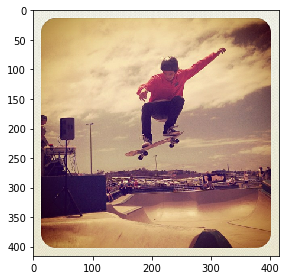

In [51]:
imshow(img.numpy()[0,:,:,:])

In [52]:
outputs = model(img)

In [53]:
real_outputs = outputs[0].numpy()[0,0:outputs[3][0].numpy(),:]*416

In [55]:
print(real_outputs)

[[159.36049   36.47315  291.1839   219.85654 ]
 [331.4134   281.0858   341.75763  297.75153 ]
 [299.37125  280.96948  310.91568  297.72556 ]
 [282.37766  277.0909   295.54773  301.2989  ]
 [260.29846  273.2665   390.19815  374.40533 ]
 [316.5251   282.3014   326.66333  296.2172  ]
 [300.8214   267.22537  308.74942  279.3556  ]
 [316.39478  264.84247  324.4557   280.94385 ]
 [157.04881  282.61307  163.9123   294.95062 ]
 [282.08456  263.73123  295.4975   283.45737 ]
 [237.61722  269.05957  244.6968   276.65503 ]
 [336.87088   41.982418 400.80762   89.67656 ]
 [380.8437   259.8978   389.26755  286.16724 ]
 [ 20.607578 242.04112  373.19617  339.87848 ]
 [348.79257  280.89032  357.14926  297.96393 ]
 [267.14685  282.50208  279.50665  297.1896  ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


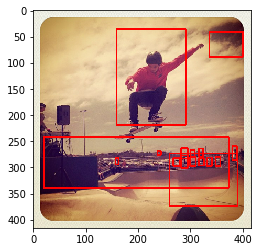

In [54]:
visualize(img.numpy()[0,:,:,:],real_outputs)